In [1]:
import cvtk

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import re
import pickle

from tqdm import tnrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
np.random.seed(0)

# Data and Annotation Loading

## load in allele frequency data

Here, we only actually have 2 controls. So I needed to duplicate these. This will likely cause problems downstream with the covariance estimations.

In [6]:
SYNC_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'
sf = vf.SyncFile(SYNC_FILE)
sf

reading file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'...
file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz' loaded.
total time to load Sync file: 0.2519448479016622 mins.


VariantFile with 166090 loci and 32 samples.

#### Next, need a file that specifies the genome. in format: scaff name, length. tab delimited.

In [7]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [8]:
sf_gi

GenomicIntervals — 9473 unique seqids, 166090 features
         GenomicInterval
0  LS387016.1:[102, 103)
1  LS387016.1:[148, 149)
2  LS387016.1:[158, 159)
3  LS387016.1:[162, 163)
4  LS387016.1:[163, 164)
[ 166085 more GenomicIntervals ]

## Study Design

In [9]:
RAW_DESIGN_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_design.csv'
sample_names = pd.read_csv(RAW_DESIGN_FILE)
#sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
#sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
design = sample_names

In [10]:
design

,name,species,pop,selection,gen,rep,id
0,AA_F00_Rep1,Atonsa,LIS,Ambient,0,1,AA-1
1,AA_F00_Rep2,Atonsa,LIS,Ambient,0,2,AA-2
2,AA_F00_Rep3,Atonsa,LIS,Ambient,0,3,AA-3
3,AA_F00_Rep4,Atonsa,LIS,Ambient,0,4,AA-4
4,AA_F25_Rep1,Atonsa,LIS,Ambient,25,1,AA-1
5,AA_F25_Rep2,Atonsa,LIS,Ambient,25,2,AA-2
6,AA_F25_Rep3,Atonsa,LIS,Ambient,25,3,AA-3
7,AA_F25_Rep4,Atonsa,LIS,Ambient,25,4,AA-4
8,AA_F00_Rep1,Atonsa,LIS,Acidic,0,1,AH-1
9,AA_F00_Rep2,Atonsa,LIS,Acidic,0,2,AH-2


Our TemporalFreqs() and TiledTemporalFreqs() objects take a list of tuples (replicate, timepoint), which we create via the design DataFrame:

In [11]:
samples = design[['id', 'gen']].copy().values.tolist()

#np.shape(samples)
#samples = [(t, r) for t, r in (design['id'].values, design['gen'].values)]
#samples = design['id','gen'].tolist()
#print(design['id'].values)
#print(design['gen'].values)
samples

[['AA-1', 0],
 ['AA-2', 0],
 ['AA-3', 0],
 ['AA-4', 0],
 ['AA-1', 25],
 ['AA-2', 25],
 ['AA-3', 25],
 ['AA-4', 25],
 ['AH-1', 0],
 ['AH-2', 0],
 ['AH-3', 0],
 ['AH-4', 0],
 ['AH-1', 25],
 ['AH-2', 25],
 ['AH-3', 25],
 ['AH-4', 25],
 ['HA-1', 0],
 ['HA-2', 0],
 ['HA-3', 0],
 ['HA-4', 0],
 ['HA-1', 25],
 ['HA-2', 25],
 ['HA-3', 25],
 ['HA-4', 25],
 ['HH-1', 0],
 ['HH-2', 0],
 ['HH-3', 0],
 ['HH-4', 0],
 ['HH-1', 25],
 ['HH-2', 25],
 ['HH-3', 25],
 ['HH-4', 25]]

## Import Annotation
These sequence lengths are used for the creation of the tiles.

In [12]:
gff_file = '/users/r/b/rbrennan/tonsa_annotation/gawn/05_results/GCA_900241095.1_Aton1.0_genomic.fa.gff3'
# remove keep seqids, I want to keep all
#keep_seqids = set('2L 2R 3L 3R 4 X'.split())
#dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))
#atonsa = GenomicIntervals.from_gff(gff_file, filter_type='exon')
atonsa = GenomicIntervals.from_gff(gff_file)

In [13]:
atonsa.infer_seqlens()

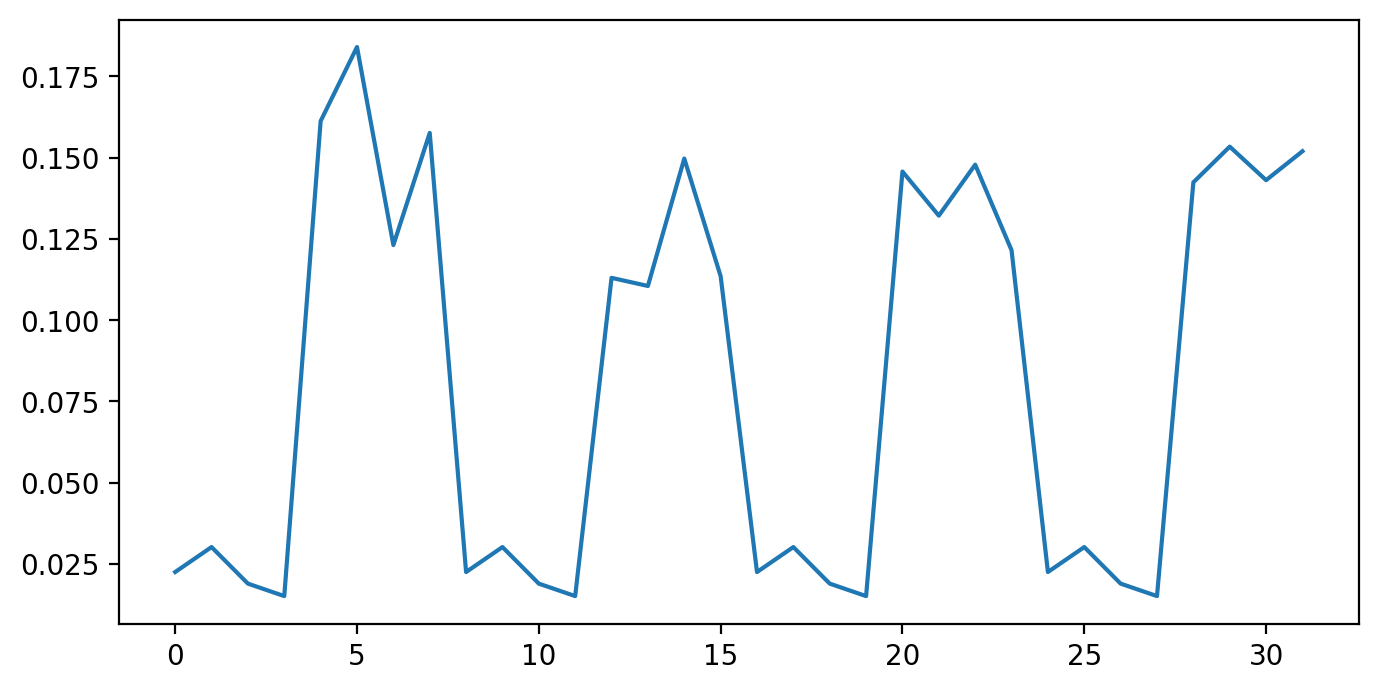

In [14]:
fixed = ((sf.freqs == 0.) | (sf.freqs == 1.))
# what percent of sites are fixed/lost through time?
plt.plot(fixed.mean(axis=0))

In [15]:
tile_width = 1e3
tile_width_label = '1e3'
tiles = GenomicIntervals.from_tiles(atonsa.seqlens, width=tile_width, drop_last_tile=False)
#tiles.intervals

In [16]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=3000, gintervals=sf_gi, samples=samples,
                       share_first=True)

In [17]:
np.amax(d.depths.flatten())

912

In [18]:
np.amin(d.depths.flatten())

40

In [19]:
print(-np.sort(-d.depths.flatten()))

[912 912 912 ...  40  40  40]


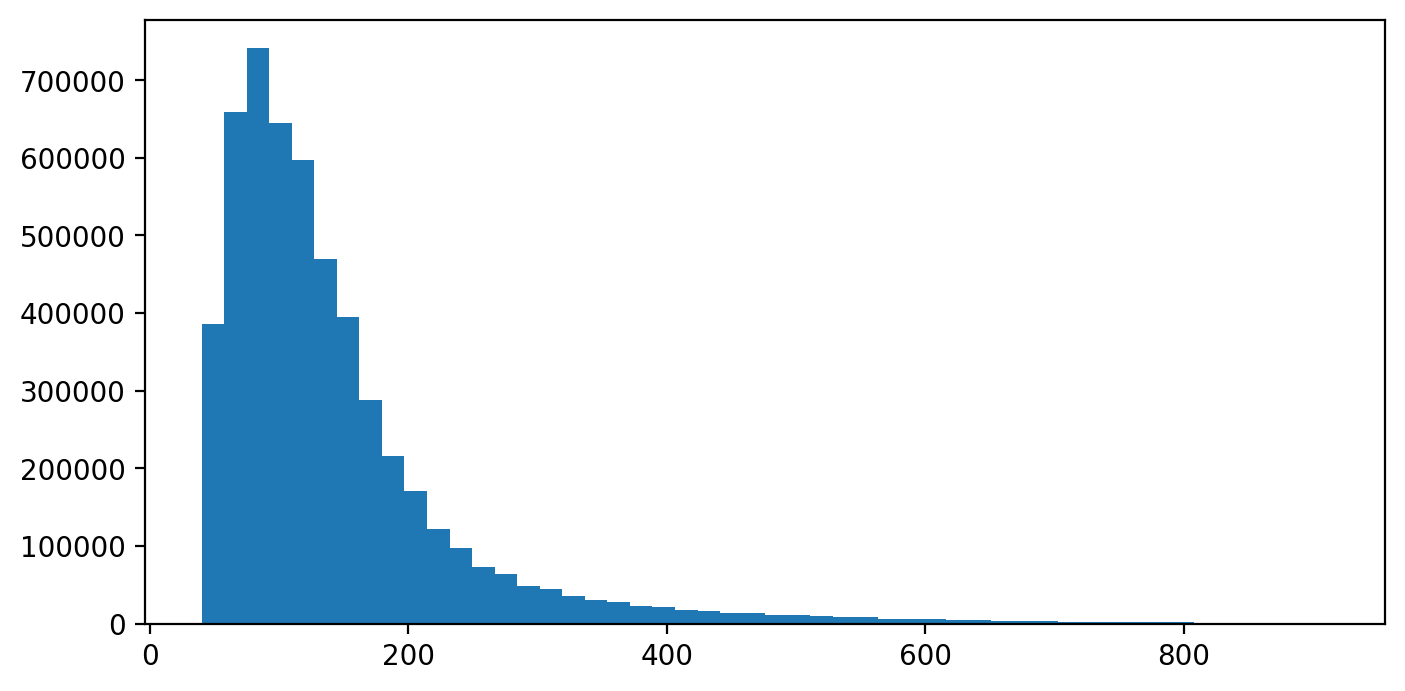

In [20]:
plt.hist(d.depths.flatten(), 50)
plt.show()

In [21]:
d.freqs.shape

(16, 2, 166090)

How many windows and what's the mean and median number of loci per window?

In [22]:
nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

12831
225635
mean number of loci: 0.6230372061072086
median number of loci: 0.0


## Genome-wide Covariances

In [23]:
gw_covs = d.calc_cov(use_masked=True, standardize=True)

In [24]:
gw_covs.shape

(16, 16)

In [25]:
stack_temporal_covariances(gw_covs, d.R, d.T).mean(axis=2)

array([[0.04607901],
       [0.04857605],
       [0.03546032],
       [0.04219185],
       [0.02287951],
       [0.03092149],
       [0.02825557],
       [0.02385176],
       [0.04238921],
       [0.0474248 ],
       [0.05289962],
       [0.04405674],
       [0.06468776],
       [0.05342451],
       [0.0485327 ],
       [0.07897597]])

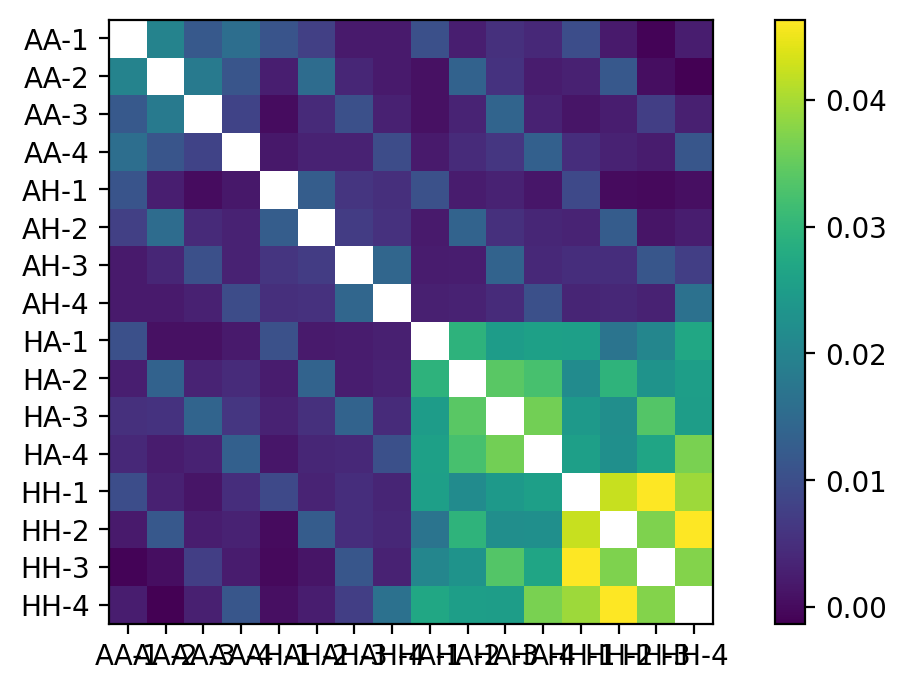

In [26]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(sample_names)))
plt.show()

## Filter windows

As this currently stands, it is filtering based on scaffold id. So we're left with many empty windows.

In [27]:
print((d.tile_indices[2]))

[70539, 70540, 70541, 70542, 70543, 70544, 70545, 70546, 70547, 70548, 70549, 70550, 70551, 70552, 70553, 70554, 70555]


In [28]:
#d.tile_df['uniqid'] = d.tile_df['seqid'] + "_" + d.tile_df['midpoint'].astype(str)

# get chrs at least 1kb, so they can have at least 1 window
x2={s:v for s,v in d.tiles.seqlens.items() if v > 999}

# can filter by the number of snps 
## each entry in tile_indices are the snps. 
## so we can drop any scaffold that has windows with zero snps (or whatever number)
min_sites = 0
keep_seqids = list(set([str(chr) for chr, indices in zip(d.tile_df['seqid'], d.tile_indices) if len(indices) > min_sites]))
#sel_chrs = ['24', '1', '9', '15']
#sel_chrs = ['24']
sel_chrs = []
keep_seqids_nolength = [chr for chr in keep_seqids if chr not in sel_chrs]
print("Number of scaffolds with at least 1 snp:",len(keep_seqids))

keep_seqids = set(keep_seqids_nolength).intersection(set(x2.keys()))

print("Number of scaffolds with at least 1 snp and 1kb in length:",len(keep_seqids))

print("Number of total tiles:",len(d.tile_indices))

Number of scaffolds with at least 1 snp: 8030
Number of scaffolds with at least 1 snp and 1kb in length: 7758
Number of total tiles: 225635


In [29]:
exclude_seqids = list(set(d.gintervals.keys()) - set(keep_seqids))
#len(exclude_seqids)

print("Number of scaffolds: ", len(set(d.gintervals.keys())))
print("Number of scaffolds excluded:", len(exclude_seqids))

Number of scaffolds:  9473
Number of scaffolds excluded: 1715


## Bootstrap whole covaraince matrix.

In [30]:
# keep_seqids was a set. need to convert
keep_seqids=list(keep_seqids)

In [31]:
# need to use CI method "standard" to deal with bias in the bootstrap
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True, ci_method="standard")

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:310: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:369: RuntimeWarning: Mean of empty slice


In [39]:
# save values:
sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

rows, cols = np.triu_indices(gw_covs_cis.shape[1], k=1)
lower, mean, upper = [gw_covs_cis[i, rows, cols].ravel() for i in np.arange(3)]
all_labels = [sample_names[i] + " " + sample_names[j] for i, j in zip(rows, cols)]
lower, upper = mean-lower, upper-mean

output = pd.DataFrame(
    {'labels': all_labels,
     'lower': lower,
     'upper': upper,
     'mean': mean
    })

output.to_csv('/users/r/b/rbrennan/tonsa_genomics/analysis/covariance_pairwise.csv', index=False)

In [41]:
gw_covs_cis[:,0,1]

array([0.01573342, 0.02134872, 0.02696402])

In [40]:
# get the bootstrap vals
gw_covs_straps = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True,
                             return_straps=True)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:310: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:369: RuntimeWarning: Mean of empty slice


mean:  0.017031574833086472
conf interval:  [0.0116916  0.02271144]


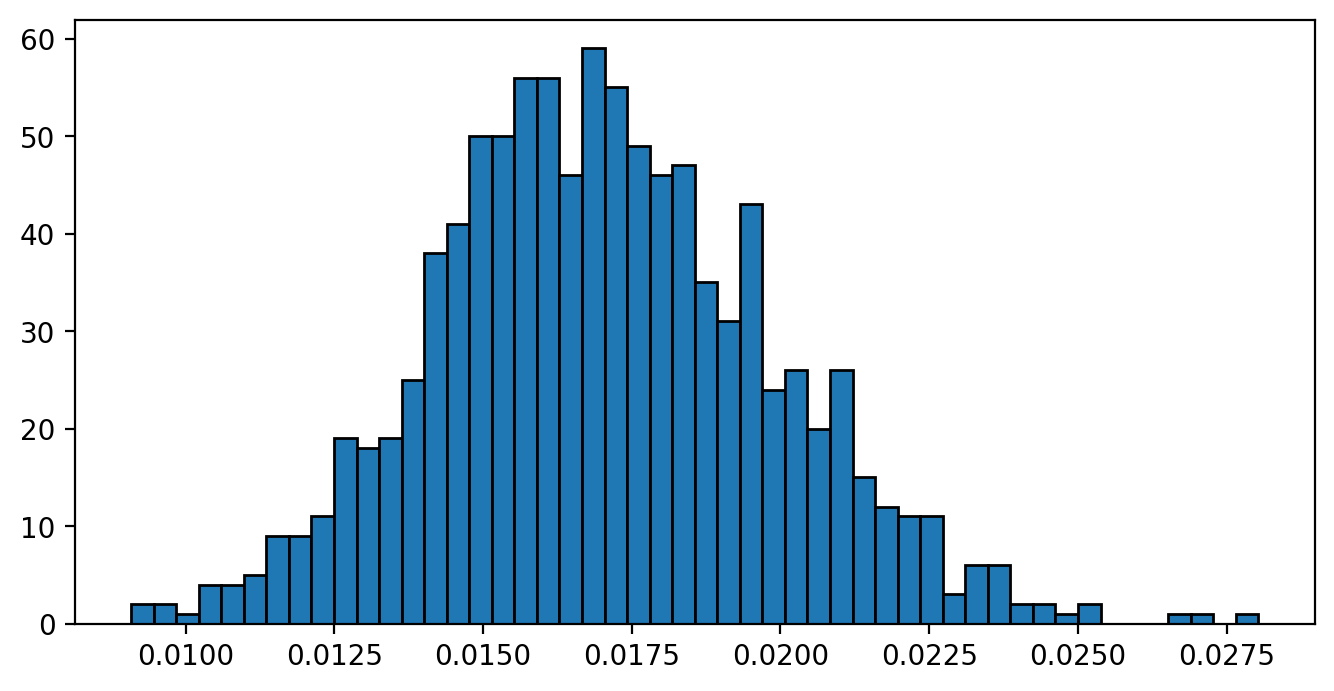

In [42]:
#print(len(gw_covs_straps[0][2]))
#print(np.ndim(gw_covs_straps[0][2]))
#print((gw_covs_straps[0][2]))
#plt.hist(gw_covs_straps[:,0,0])
straps, weights = gw_covs_straps
mn_all = np.mean(straps[:,0,1])
print("mean: ", mn_all)
conf_interval = np.percentile(straps[:,0,1],[2.5,97.5])
print("conf interval: ", conf_interval)
plt.hist(straps[:,0,1], bins=50, edgecolor='black')
#gw_covs_straps
#plt.hist(weights, bins=100)
array_masked = np.ma.masked_invalid(straps[:,0,0])
#print(np.ma.average(array_masked, axis=0, weights=weights).data)
#print(array_masked)

<ipython-input-43-22e566aa1ead>:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)


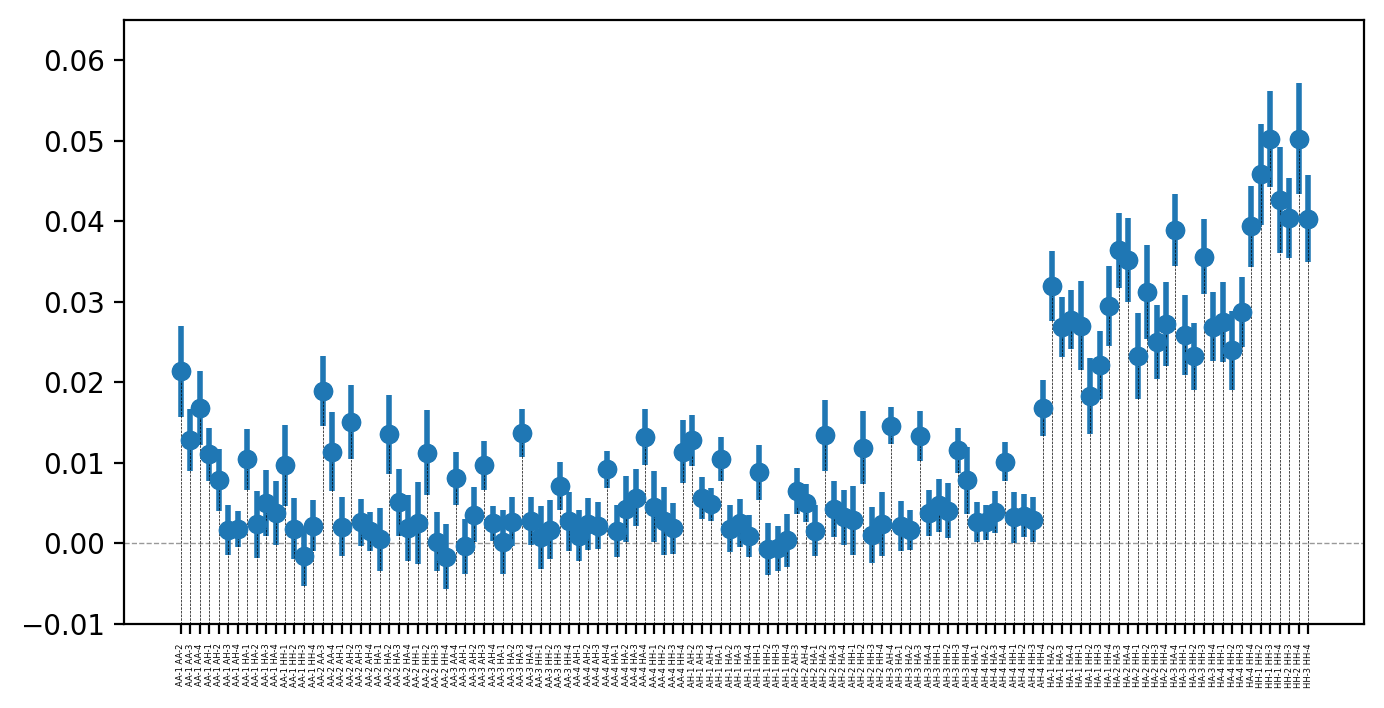

In [43]:

def rep_cov_plot(cis, labels='', filename=''):
    rows, cols = np.triu_indices(cis.shape[1], k=1)
    lower, mean, upper = [cis[i, rows, cols].ravel() for i in np.arange(3)]
    all_labels = [labels[i] + " " + labels[j] for i, j in zip(rows, cols)]
    lower, upper = mean-lower, upper-mean
    bounds = np.stack([lower, upper])
    plt.figure(figsize=(8,4)) 
    plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1.5, elinewidth=2)
    plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
    plt.xticks(rotation='vertical',fontsize=3)
    markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
    plt.setp(stemline, linewidth = 0.25)
    plt.setp(baseline, 'linewidth', 0)
    plt.ylim([-0.01, 0.065])
    plt.savefig(filename, bbox_inches='tight')



sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

rep_cov_plot(gw_covs_cis, sample_names,"/users/r/b/rbrennan/tonsa_genomics/figures/covariance_pairwise.pdf")


In [43]:
# print(gw_covs_cis)

### PCA

[2.44126727e-01 1.19616623e-01 7.97080777e-02 6.65235135e-02
 5.13728763e-02 4.79454608e-02 4.10488356e-02 4.07896081e-02
 3.64815682e-02 3.55398993e-02 3.36821616e-02 3.27103153e-02
 3.03788341e-02 2.55850258e-02 2.52654196e-02 2.44963441e-02
 2.27156502e-02 2.19216985e-02 2.00913615e-02 7.12557156e-30
 9.35461306e-31 1.36873250e-31 3.47585762e-32 1.05895176e-32
 1.09961019e-33 1.09961019e-33 1.09961019e-33 1.09961019e-33
 1.09961019e-33 1.09961019e-33 1.09961019e-33 2.64758569e-34]


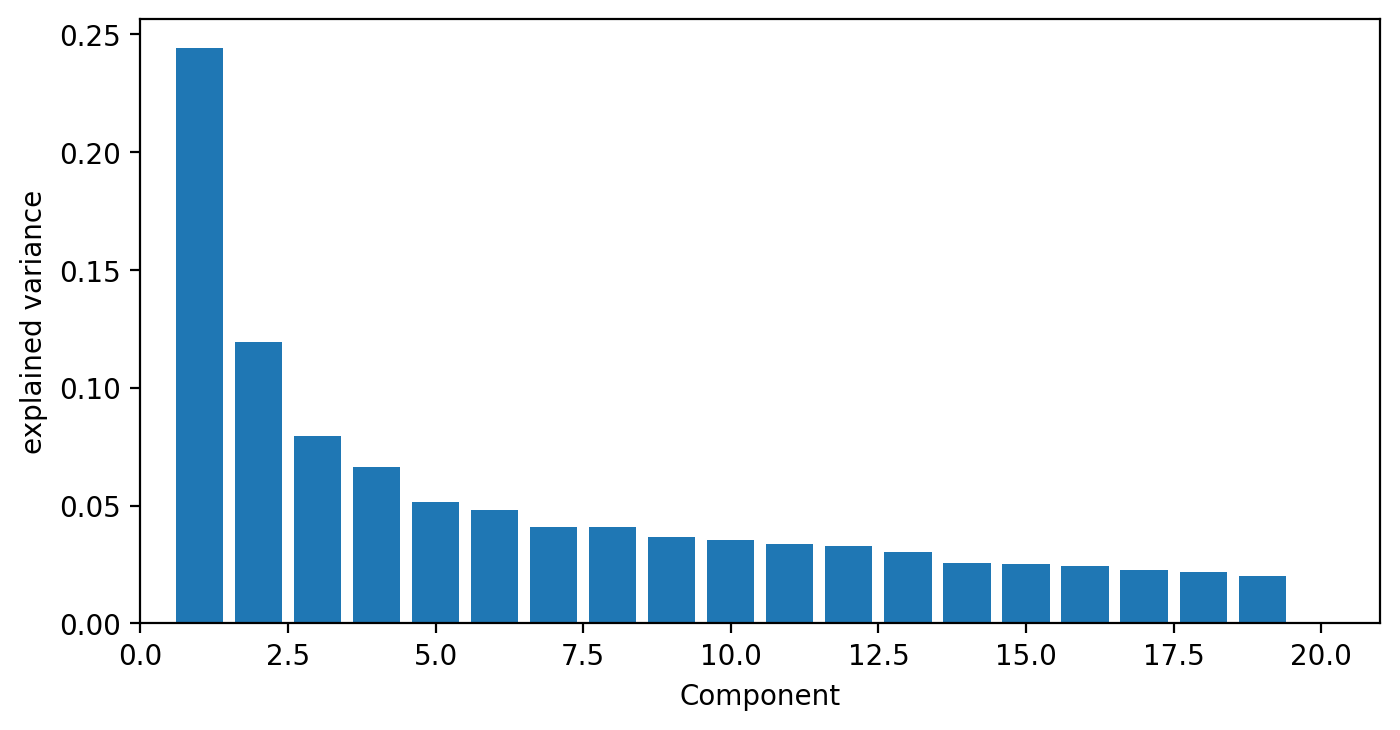

In [44]:
pca = FreqPCA(sf.freqs)
pc_df= pca.to_df()
# add in the sample info:
pc_df[['rep', 'gen', 'id', 'selection']] = design[['rep', 'gen', 'id', 'selection']]
#pc_df.to_csv('../data/e/pca_df.csv', index=False)


def rep_plot_pca3(df, x=1, y=2, s=300, figsize=None, dpi=None, label=True, cmap=None,
                  fontsize=12, variance=None):
    l1, l2 = f"pc{int(x)}", f"pc{int(y)}"
    pc1, pc2 = df[l1], df[l2]
    gen, rep = df['gen'], df['rep']
    ids = df['id']
    selection = df['selection']
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    groups = df.groupby("selection")
    for name, group in groups:
        ax.scatter(group['pc1'], group['pc2'], label=name)
    #ax.scatter(pc1, pc2, c=selection)
    # plot lines between consecutive generations
    for r in rep.unique():
        this_rep = df[df['rep'] == r]
        ax.plot(this_rep[l1], this_rep[l2], '--', color='0.8', zorder=-1)
    # each marker gets a label, of the current replicate
    label_df = df[[l1, l2, 'rep', 'gen', 'id', 'selection']]
    if label:
        for i, point in label_df.iterrows():
                 ax.text(point['pc1'], point['pc2'], str(point['id']),
                                 horizontalalignment='center',verticalalignment='center', fontsize=fontsize)
    if variance is not None:
        pc1=str('%.2f' % variance[0])
        pc2=str('%.2f' % variance[1])
        ax.set_xlabel(l1.upper()+": "+ pc1 )
        ax.set_ylabel(l2.upper()+": "+ pc2 )
    else:
        ax.set_xlabel(l1.upper())
        ax.set_ylabel(l2.upper())
    ax.legend()
    #plt.tight_layout()
    return fig, ax

explained_variance_ratio = pca.explained_variance / np.sum(pca.explained_variance)
print(explained_variance_ratio)
len(np.cumsum(explained_variance_ratio))
plt.bar(range(1,33),explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('explained variance')
#plt.ylim(0,1.05)
plt.xlim(0,21);

(<Figure size 1600x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5af48721f0>)

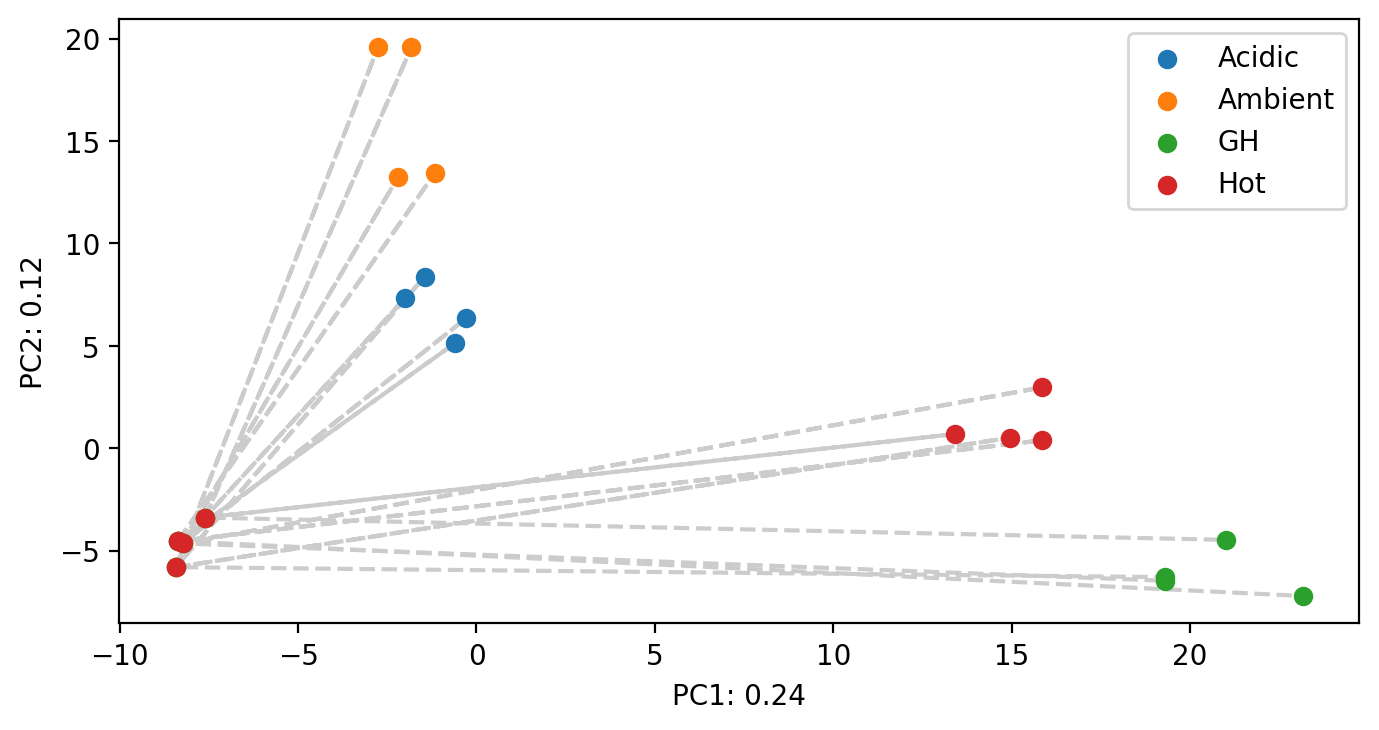

In [45]:
explained_variance_ratio = pca.explained_variance / np.sum(pca.explained_variance)

rep_plot_pca3(pc_df, 1,2, variance=explained_variance_ratio, label=False)

## Bias correction

In [46]:
diagnostics = d.correction_diagnostics(exclude_seqids=exclude_seqids)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cvtk.py:253: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cvtk.py:267: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:310: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:342: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered

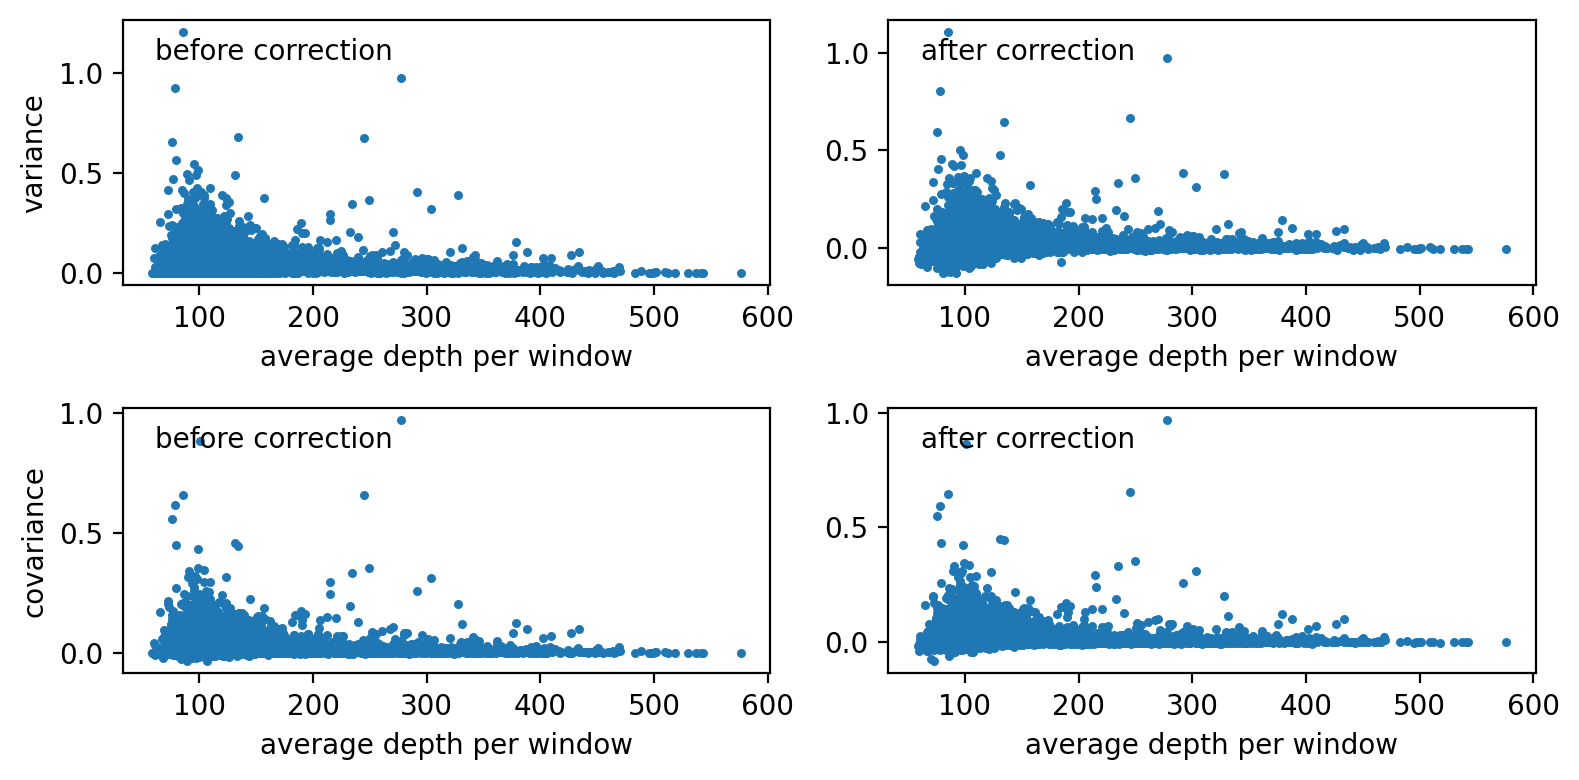

In [47]:
# _ = correction_diagnostic_plot(diagnostics, color=False)
# diagnostic plot from package threw error.
def correction_diagnostic_plot(diag, figsize=None, color=True):
    corr_df, models, xpreds, ypreds = diag
    if figsize is not None:
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    else:
        fig, ax = plt.subplots(ncols=2, nrows=2)
    labelx, labely = 0.05, 0.85
    before = corr_df[corr_df['correction'] == False]
    after = corr_df[corr_df['correction'] == True]
    if color:
        ax[0, 0].scatter(before['depth'], before['diag'], c=integerize(before['seqid']), s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], c=integerize(before['seqid']), s=5)
    else:
        ax[0, 0].scatter(before['depth'], before['diag'], s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], s=5)
    ax[0, 0].plot(xpreds[False], ypreds[False][0], 'r-')
    ax[0, 1].plot(xpreds[True], ypreds[True][0], 'r-')
    ax[0, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
    ax[0, 0].set_ylabel('variance')
    ax[0, 0].set_xlabel('average depth per window')
    ax[0, 1].set_xlabel('average depth per window')
    ax[0, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')

    ax[1, 0].plot(xpreds[False], ypreds[False][1], 'r-')
    ax[1, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
#    ax[1, 0].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_ylabel('covariance')
    if color:
        ax[1, 0].scatter(before['depth'], before['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
    else:
        ax[1, 0].scatter(before['depth'], before['offdiag'], zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], zorder=2, s=5)
    ax[1, 1].plot(xpreds[True], ypreds[True][1], 'r-')
    ax[1, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')
 #   ax[1, 1].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_xlabel('average depth per window')
    ax[1, 1].set_xlabel('average depth per window')
    plt.tight_layout()
    return fig, ax

_ = correction_diagnostic_plot(diagnostics, color=False)

## Bootstrap Convergence Correlation

Convergence Correlation per Comparison

In [48]:
import itertools
from cvtk.bootstrap import block_bootstrap

In [49]:
## using the more

In [60]:
conv_corr = d.convergence_corr()
conv_corr

array([[[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [51]:
convergence_corr = d.bootstrap_convergence_corr(B=10, progress_bar=True)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:310: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:342: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:369: RuntimeWarning: Mean of empty slice


/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/bootstrap.py:87: RuntimeWarning: divide by zero encountered in true_divide


/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3955: RuntimeWarning: invalid value encountered in add
  r = add(x1, x2)


In [55]:
#combs = list(itertools.combinations(range(0,16),2))
# just run a couple, to act as example
combs = list(itertools.combinations(range(0,3),2))

outlist = []

for x in combs:
    outlist.append(
                    d.bootstrap_convergence_corr(B=1000, 
                                                 progress_bar=True, subset=(x[0], x[1]),
                                                 ci_method='standard'))
    print("done with rep", x)


done with rep (0, 1)


/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


KeyboardInterrupt: 

In [56]:
combined_conv_corrs = np.stack(outlist).squeeze()
#np.savetxt('/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/combined_conv_corrs.csv', combined_conv_corrs, delimiter=',')

combined_conv_corrs

array([[nan, nan],
       [nan, nan],
       [nan, nan]])

<ipython-input-51-b882f8c043b7>:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(all_labels, mean, linefmt = ':')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 <a list of 28 Text major ticklabel objects>)

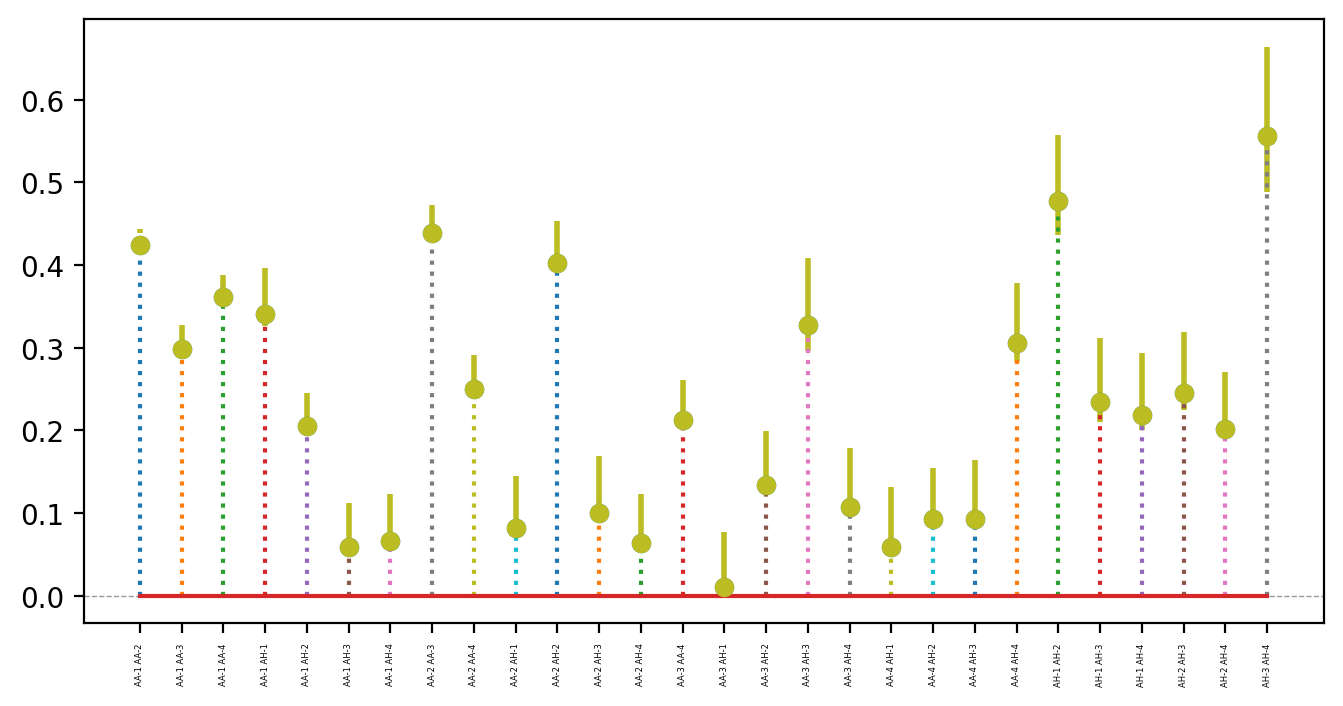

In [51]:
#plt.plot([1, 2, 3, 4])
#plt.ylabel('some numbers')
#plt.show()
    
mean = np.array([x[1] for x in combined_conv_corrs])
lower = np.array([x[0] for x in combined_conv_corrs])
upper = np.array([x[2] for x in combined_conv_corrs])

#print(lower)
#print(mean)
#print(upper)
#upper

all_labels = [sample_names[i[0]] + " " + sample_names[i[1]] for i in combs]

lower_bound, upper_bound = lower-mean, upper-mean

bounds = [lower_bound, upper_bound]
#print(bounds)
#fig = plt.figure()
plt.stem(all_labels, mean, linefmt = ':')

plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1, elinewidth=2)
plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
plt.xticks(rotation='vertical',fontsize=3)

#locs, labels = plt.xticks()
#print(labels)
#plt.axvline(x=locs, c='0.4', linewidth=0.5, linestyle="--")


#sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

#rep_cov_plot(gw_covs_cis, sample_names)

## Genome-wide G
Averaging across replicates:

In [145]:
g_averep = d.calc_G(average_replicates=True)
with open('g_averep_AA.npy', 'wb') as f:
    np.save(f, g_averep)

[0.0068427  0.00763205 0.00562077 0.00643777 0.00460229 0.00545168
 0.0056563  0.00479205 0.00678134 0.00715281 0.00751153 0.00673621
 0.00840517 0.00797725 0.00734381 0.0101022 ]


AssertionError: 

Not averaging across replicates:

In [22]:
g = d.calc_G(average_replicates=False)
with open('g.npy', 'wb') as f:
    np.save(f, g)

### Partitioning Variance into Shared and Unique Contributions

First, total variance to af change

In [146]:
gw_vars = d.calc_var()
gw_covs = d.calc_cov()

print((gw_vars))

ambient = (gw_covs[0,1] + gw_covs[0,2] + gw_covs[0,3] + gw_covs[1,2] + gw_covs[1,3] + gw_covs[2,3])/6  
acidic  = (gw_covs[4,5] + gw_covs[4,6] + gw_covs[4,7] + gw_covs[5,6] + gw_covs[5,7] + gw_covs[6,7])/6  
warm    = (gw_covs[8,9] + gw_covs[8,10] + gw_covs[8,11] + gw_covs[9,10] + gw_covs[9,11] + gw_covs[10,11])/6  
GH      = (gw_covs[12,13] + gw_covs[12,14] + gw_covs[12,15] + gw_covs[13,14] + gw_covs[13,15] + gw_covs[14,15])/6  

print(ambient)
print(acidic)
print(warm)
print(GH)

ambient1 = (gw_vars[0] + gw_vars[1] + gw_vars[2] + gw_vars[3])/4
acidic1  = (gw_vars[4] + gw_vars[5] + gw_vars[6] + gw_vars[7])/4
warm1    = (gw_vars[8] + gw_vars[9] + gw_vars[10] + gw_vars[11])/4
GH1      = (gw_vars[12] + gw_vars[13] + gw_vars[14] + gw_vars[15])/4  

print(ambient1)
print(acidic1)
print(warm1)
print(GH1)

#then estimate Ne with:

#(V(Pt-P0)/P0(1-P0))=t/2Ne
# where the left side of this is equal to the var estimate, above.
print('Ambient Ne:', 25/(2*ambient1))
print('Acidic Ne:', 25/(2*acidic1))
print('Warm Ne:', 25/(2*warm1))
print('GH Ne:', 25/(2*GH1))

[0.0068427  0.00763205 0.00562077 0.00643777 0.00460229 0.00545168
 0.0056563  0.00479205 0.00678134 0.00715281 0.00751153 0.00673621
 0.00840517 0.00797725 0.00734381 0.0101022 ]
[0.0536936  0.05614773 0.04301417 0.04971336 0.03049409 0.03849317
 0.03580942 0.03137327 0.0500038  0.05499648 0.06045347 0.05157825
 0.07230234 0.06099619 0.05608655 0.08649747]
0.014297078696959883
0.008490389659079342
0.03052405536188237
0.0415057912635398
0.050642215326101234
0.034042487226098914
0.054257997268931324
0.0689706395938151
Ambient Ne: 246.82964438874856
Acidic Ne: 367.1882115128411
Warm Ne: 230.38078493836383
GH Ne: 181.23653881732207


In [147]:
from cvtk.bootstrap import bootstrap_ci, block_bootstrap_ratio_averages

In [148]:
windowed_covs = d.calc_cov_by_tile()

In [149]:
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

### shared change due to selection:
    mean(cov between each replicate in that treatment) - mean(cov with ambient control)/(total variance)

In [183]:
# shared change due to Acidic selection

sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
# rows and cols should match sample names, above
gw_covs = d.calc_cov()
gw_covs

shared = (gw_covs[4,5] + gw_covs[4,6] + gw_covs[4,7] + gw_covs[5,6] + gw_covs[5,7] + gw_covs[6,7])/6  
lab = (gw_covs[0,4] + gw_covs[0,5] + gw_covs[0,6] + gw_covs[0,7] + gw_covs[1,4] + gw_covs[1,5] + gw_covs[1,6] + gw_covs[1,7] + gw_covs[2,4] + gw_covs[2,5] + gw_covs[2,6] + gw_covs[2,7] + gw_covs[3,4] + gw_covs[3,5] + gw_covs[3,6] + gw_covs[3,7])/16
total = (gw_covs[4,4] + gw_covs[5,5] + gw_covs[6,6] + gw_covs[7,7])/4

selection = (shared - lab)/total

print('acidic treatment:')
print('shared:', shared/total)
print('lab:', lab/total)
print('total:', total)
print('selection:', selection)


acidic treatment:
shared: 0.3206693862968973
lab: 0.197505313947834
total: 0.026477082072369606
selection: 0.12316407234906328


In [184]:
# need function to bootstrap over
def unique_shared(cov):
    shared = (cov[4,5] + cov[4,6] + cov[4,7] + cov[5,6] + cov[5,7] + cov[6,7])/6  
    lab = (cov[0,4] + cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7])/16
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    #selection = (shared - lab)
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)
print('shared:', shared/total)
print('lab:', lab/total)
#print('selection:', selection/total)

shared: 0.3206693862968973
lab: 0.197505313947834


In [152]:
from cvtk.bootstrap import bootstrap_ci, block_bootstrap_ratio_averages

In [178]:
windowed_covs = d.calc_cov_by_tile()

In [179]:
len(windowed_covs)

42972

In [171]:
windowed_covs_narm = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any() and ~np.isinf(windowed_covs).any()]

In [172]:
len(windowed_covs_narm)

9073

In [180]:
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])
windowed_stats[0]

array([0.04150579, 0.00789865, 0.03056365])

In [189]:
# bootstrap indiv values

B = 1000

# the output from windowed_stats is shared, lab, total

# set up variables outside of loop:
## calc the total variance for ACIDIC,
vars = np.array([(win[4,4] + win[5,5] + win[6,6] + win[7,7])/4 for win in windowed_covs])

# hold output:
shared_straps, lab_straps, selection_straps, total_straps = [], [], [], []

# loop is below here
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    var_ls = np.nanmean(vars[bidx])
    s, l, t = np.nanmean(windowed_stats[bidx], axis=0)
    # I want
    shared_straps.append(s/var_ls)
    lab_straps.append(l/var_ls)
    selection_straps.append((s-l)/var_ls)
    total_straps.append(t)

<ipython-input-189-8e9a84a1e514>:21: RuntimeWarning: invalid value encountered in double_scalars
  lab_straps.append(l/var_ls)
<ipython-input-189-8e9a84a1e514>:22: RuntimeWarning: invalid value encountered in double_scalars
  selection_straps.append((s-l)/var_ls)


shared: [ nan 32.1  nan]
0.3206693862968973


ValueError: autodetected range of [nan, nan] is not finite

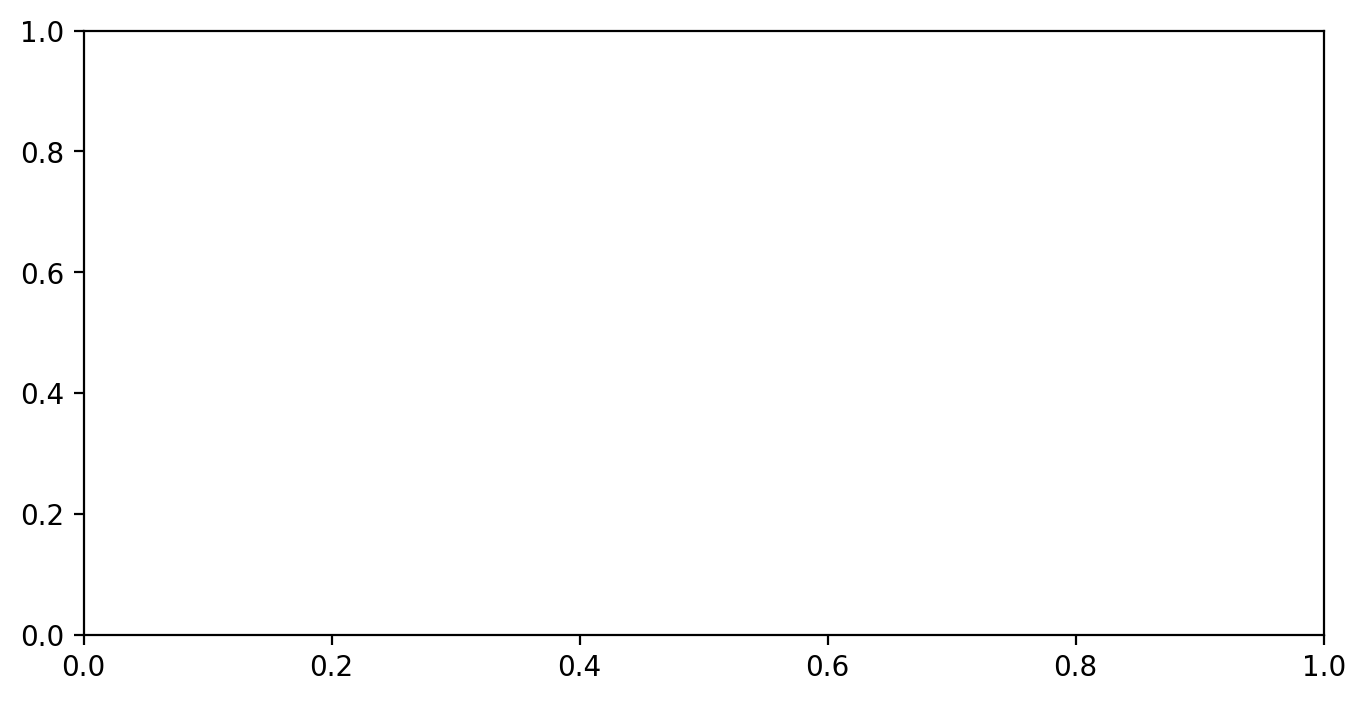

In [185]:
# need total variation:
ls_var = (gw_covs[1,1] + gw_covs[2,2])/2

# also need estimated values from all data:

# then bootstrap

print('shared:', (bootstrap_ci(shared/total, shared_straps, method="standard") * 100).round(1))
print(shared/total)

plt.hist(shared_straps)

In [176]:
#windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])
windowed_stats[bidx]
windowed_stats = np.array([win[0] for win in windowed_stats[bidx]])

### repeat for GH

In [163]:
# need function to bootstrap over
def unique_shared(cov):
    shared = (gw_covs[12,13] + gw_covs[12,14] + gw_covs[12,15] + gw_covs[13,14] + gw_covs[13,15] + gw_covs[14,15])/6  
    lab = (cov[0,12] + cov[0,13] + cov[0,14] + cov[0,15] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7])/16
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    #selection = (shared - lab)
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)
print('shared:', shared/total)
print('lab:', lab/total)
#print('selection:', selection/total)

windowed_covs = d.calc_cov_by_tile()

windowed_covs_narm = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any()]

print(len(windowed_covs_narm))

windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])

# figure out how to calc indiv values

# the output from windowed_stats is shared, lab, total

# set up variables outside of loop:
## calc the total variance for ACIDIC,
vars = np.array([(win[4,4] + win[5,5] + win[6,6] + win[7,7])/4 for win in windowed_covs_narm])

# hold output:
shared_straps, lab_straps, selection_straps, total_straps = [], [], [], []

# loop is below here
# bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
bidx = 0
var_ls = vars[bidx]
s, l, t = windowed_stats[bidx, :]
# I want
shared_straps.append(s/var_ls)
lab_straps.append(l/var_ls)
selection_straps.append((s-l)/var_ls)
total_straps.append(t)

print(l)

shared: 1.5676119879861512
lab: 0.17512071755421
9103
0.007898648925982419


In [164]:
print(shared_straps)
print(lab_straps)
print(selection_straps)
print(total_straps)

[1.3580116792155161]
[0.2584327913037458]
[1.0995788879117703]
[0.03056364823571804]


In [165]:
B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])
vars = np.array([(win[1,1] + win[2,2])/2 for win in windowed_covs])
uni_straps, shared_straps, total_sel_straps = [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    u, s = windowed_stats[bidx, :].mean(axis=0)
    var_ls = vars[bidx].mean()
    b =(u + s) / var_ls
    uni_straps.append(u/var_ls)
    shared_straps.append(s/var_ls)
    total_sel_straps.append(b)
    
ls_var = (gw_covs[1,1] + gw_covs[2,2])/2
print('unique:', (bootstrap_ci(uni/ls_var, uni_straps, method="standard") * 100).round(1))
print('shared:', (bootstrap_ci(shared/ls_var, shared_straps) * 100).round(1))
print('total sel:', (bootstrap_ci((uni + shared)/ls_var, total_sel_straps) * 100).round(1))

IndexError: index 20105 is out of bounds for axis 0 with size 9103

#### Shared response between treatments:

shared_cov = mean(cov between replicates of the two treatments)  
lab_cov = mean(cov between each replicate and the control)

then the total shared covariance without lab effects:

(shared_cov - lab_cov) / (total variance)

In [73]:
# shared change in Acidic vs GH

sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
# AH is 4:7
# HA is 8:11
# HH is 12:15
shared_cov = (gw_covs[4,12] + gw_covs[4,13] + gw_covs[4,14] + gw_covs[4,15] + gw_covs[5,12] + gw_covs[5,13] + gw_covs[5,14] + gw_covs[5,15] + gw_covs[6,12] + gw_covs[6,13] + gw_covs[6,14] + gw_covs[6,15] + gw_covs[7,12] + gw_covs[7,13] + gw_covs[7,14] + gw_covs[7,15])/16
lab_cov = (gw_covs[0,4] + gw_covs[0,5] + gw_covs[0,6] + gw_covs[0,7] + gw_covs[1,4] + gw_covs[1,5] + gw_covs[1,6] + gw_covs[1,7] + gw_covs[2,4] + gw_covs[2,5] + gw_covs[2,6] + gw_covs[2,7] + gw_covs[3,4] + gw_covs[3,5] + gw_covs[3,6] + gw_covs[3,7] +gw_covs[0,12] + gw_covs[0,13] + gw_covs[0,14] + gw_covs[0,15] + gw_covs[1,12] + gw_covs[1,13] + gw_covs[1,14] + gw_covs[1,15] + gw_covs[2,12] + gw_covs[2,13] + gw_covs[2,14] + gw_covs[2,15] + gw_covs[3,12] + gw_covs[3,13] + gw_covs[3,14] + gw_covs[3,15])/32
total = (gw_covs[4,4] + gw_covs[5,5] + gw_covs[6,6] + gw_covs[7,7] + gw_covs[12,12] + gw_covs[13,13] + gw_covs[14,14] + gw_covs[15,15] )/8

shared_nolab = (shared_cov - lab_cov) / (total)

print('acidic vs gh treatment:')
print('shared:', shared_cov/total)
print('lab:', lab_cov/total)
print('total:', total)
print('shared no lab:', shared_nolab)

acidic vs gh treatment:
shared: 0.12193892303919963
lab: 0.10488831685711167
total: 0.04394115825622771
shared no lab: 0.01705060618208797
